In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

from datetime import datetime;now = datetime.now;t00=now();

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done, mounted
2020-11-03 16:49:36.681362


In [3]:
#data = np.random.rand(131,160,64,64)
#data = np.load('/content/drive/My Drive/abide_data_60.npy')
data = np.load('/content/drive/My Drive/abide_data_60iso_1060.npy')

for s in range(data.shape[0]):
  data[s,:,:,:] = (data[s,:,:,:]-data[s,:,:,:].min()) / (data[s,:,:,:].max()-data[s,:,:,:].min())
  
print(data.shape)

(1060, 1, 64, 64, 64)


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [5]:
# Autoencoder class
class CAE(nn.Module):
    def __init__(self,input_shape,k=1):
        super().__init__()
        
        # Stuff
        self.input_shape = input_shape
        self.batch_size = input_shape[0]

        self.lrelu = torch.nn.LeakyReLU(negative_slope=.02)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Shapes and sizes
        #R = np.ones(shape=self.input_shape)
        #R = torch.tensor(R).float()

        bias_bool = False # Do you want padding or not 

        # Encoder
        self.enc_C1 = nn.Conv3d(in_channels=1,out_channels=int(4*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C2 = nn.Conv3d(in_channels=int(4*k),out_channels=int(8*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C3 = nn.Conv3d(in_channels=int(8*k),out_channels=int(16*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C4 = nn.Conv3d(in_channels=int(16*k),out_channels=int(32*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C5 = nn.Conv3d(in_channels=int(32*k),out_channels=int(64*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)

        self.batchNormE1 = nn.BatchNorm3d(int(4*k), affine=False)
        self.batchNormE2 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormE3 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormE4 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormE5 = nn.BatchNorm3d(int(64*k), affine=False)

        self.batchNormD1 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormD2 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormD3 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormD4 = nn.BatchNorm3d(int(4*k), affine=False)
        #self.batchNormD5 = nn.BatchNorm3d(int(4*k), affine=False)

        self.dec_C1 = nn.ConvTranspose3d(in_channels=int(64*k),out_channels=int(32*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C2 = nn.ConvTranspose3d(in_channels=int(32*k),out_channels=int(16*k),kernel_size=4, stride=2, padding=1,bias=bias_bool) 
        self.dec_C3 = nn.ConvTranspose3d(in_channels=int(16*k),out_channels=int(8*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C4 = nn.ConvTranspose3d(in_channels=int(8*k),out_channels=int(4*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C5 = nn.ConvTranspose3d(in_channels=int(4*k),out_channels=1,kernel_size=4, stride=2, padding=1,bias=bias_bool)

    def forward(self,hello):
      
        activation = self.relu( self.enc_C1(hello) )
        activation = self.batchNormE1(activation)

        activation = self.relu( self.enc_C2(activation) )
        activation = self.batchNormE2(activation)

        activation = self.relu( self.enc_C3(activation) )
        activation = self.batchNormE3(activation)

        activation = self.relu( self.enc_C4(activation) )
        activation = self.batchNormE4(activation)

        activation = self.relu( self.enc_C5(activation) )
        activation = self.batchNormE5(activation)

        activation = self.relu( self.dec_C1(activation))
        activation = self.batchNormD1(activation)

        activation = self.relu( self.dec_C2(activation) )
        activation = self.batchNormD2(activation)

        activation = self.relu( self.dec_C3(activation) )
        activation = self.batchNormD3(activation)

        activation = self.relu( self.dec_C4(activation) )
        activation = self.batchNormD4(activation)

        activation = self.relu( self.dec_C5(activation) )
        #activation = self.batchNormD5(activation)

        return activation


In [6]:
# D = torch.tensor(data[:,:,:,:,:]).float()
# data_batch = D[0:5,:,:,:,:]

# modelPlay = CAE(data_batch.shape,k=.5)
# 



In [7]:
## Convert data 
D = torch.tensor(data[:,:,:,:,:]).float()
#D = torch.tensor(np.random.rand(1060, 1, 64, 64, 64)*.001).float()
#D = (D-D.min()) / (D.max()-D.min())
data_batch = D[0:5,:,:,:,:]

## Model Definition
model = CAE(data_batch.shape,k=25) # Initiate mode

latentSpaceSize = model.enc_C5(model.enc_C4(model.enc_C3(model.enc_C2(model.enc_C1(data_batch))))).shape
print(f"latentSpaceSize: {latentSpaceSize}")
latentSpaceDim = np.prod(latentSpaceSize)
print(f"latentSpaceDim: {latentSpaceDim/latentSpaceSize[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  use gpu if available
model.to(device)

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model.apply(weights_init_uniform_rule)

#model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-3,)
optimizer = optim.Adam(model.parameters(), lr=.01,weight_decay=.01)
#optimizer = optim.SGD(model.parameters(),lr=.001,weight_decay=.0,momentum=.0)
#optimizer = optim.RMSprop(model.parameters(),lr=.1)
#criterion = nn.MSELoss()
print(device)

## Training Parameters
num_epochs = 501
batch_size = 5
ndata = data.shape[0]
n_batches = np.floor(D.shape[0]/5)
batches = np.array([np.arange((i)*5,(i+1)*5) for i in range(int(n_batches))])
D = D.cuda()
track = list();

ofdir = os.path.join(os.path.curdir,'drive','My Drive','BC-MRI-AE','models')
print(ofdir)

session_name = '5layer-256-batchNorm'

latentSpaceSize: torch.Size([5, 1600, 2, 2, 2])
latentSpaceDim: 12800.0
cuda
./drive/My Drive/BC-MRI-AE/models


In [8]:
def myLoss(outputs,data_batch):
  return torch.sum(torch.square(outputs.view(-1)-data_batch.view(-1)))

epoch 0/501 | batch 0/212.0 | time 0:00:00.807013 | loss 2510065.0
epoch 0/501 | batch 50/212.0 | time 0:00:31.730403 | loss 52963.84766
epoch 0/501 | batch 100/212.0 | time 0:01:03.245562 | loss 29668.375
epoch 0/501 | batch 150/212.0 | time 0:01:35.591073 | loss 27220.2832
epoch 0/501 | batch 200/212.0 | time 0:02:08.820145 | loss 146526.5625
saved
./drive/My Drive/BC-MRI-AE/models/5layer-256-batchNorme0_2020-11-03 16:53:14.450008
tensor([0.0000, 0.0451, 0.0000,  ..., 0.0041, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<ViewBackward>)


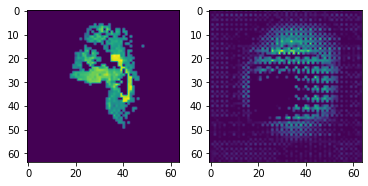

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


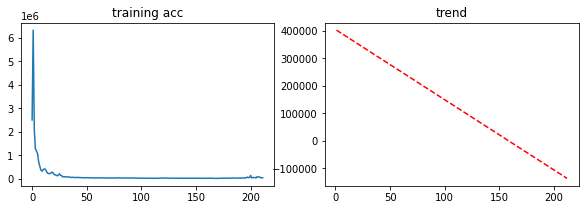

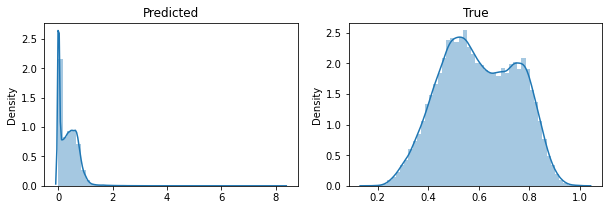

epoch 1/501 | batch 0/212.0 | time 0:02:28.614258 | loss 67784.0
epoch 1/501 | batch 50/212.0 | time 0:03:01.853111 | loss 46977.98438
epoch 1/501 | batch 100/212.0 | time 0:03:35.186095 | loss 34134.53125
epoch 1/501 | batch 150/212.0 | time 0:04:08.385300 | loss 22138.19531
epoch 1/501 | batch 200/212.0 | time 0:04:41.831273 | loss 18383.79297
epoch 2/501 | batch 0/212.0 | time 0:04:49.840011 | loss 18298.45703
epoch 2/501 | batch 50/212.0 | time 0:05:23.089655 | loss 16393.32422
epoch 2/501 | batch 100/212.0 | time 0:05:56.415257 | loss 20633.19141
epoch 2/501 | batch 150/212.0 | time 0:06:29.819562 | loss 15039.3291
epoch 2/501 | batch 200/212.0 | time 0:07:03.011945 | loss 15562.69238
epoch 3/501 | batch 0/212.0 | time 0:07:11.000398 | loss 16762.55078
epoch 3/501 | batch 50/212.0 | time 0:07:44.304582 | loss 27307.46484
epoch 3/501 | batch 100/212.0 | time 0:08:17.530827 | loss 14977.96484
epoch 3/501 | batch 150/212.0 | time 0:08:50.931711 | loss 37014.84375
epoch 3/501 | batch 

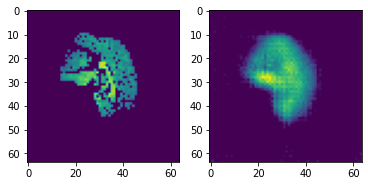

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


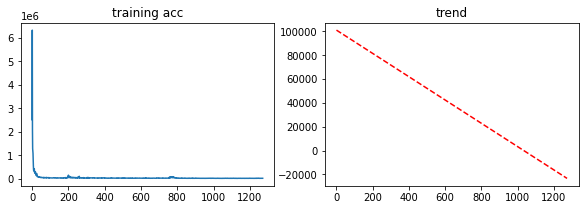

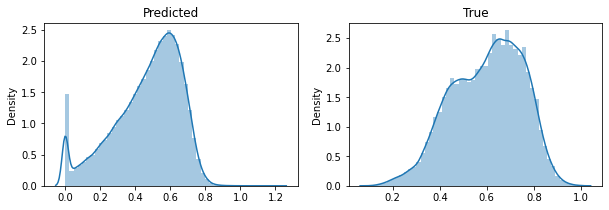

epoch 6/501 | batch 0/212.0 | time 0:14:19.554181 | loss 11437.02441
epoch 6/501 | batch 50/212.0 | time 0:14:52.871572 | loss 11966.42383
epoch 6/501 | batch 100/212.0 | time 0:15:26.159629 | loss 11723.91992
epoch 6/501 | batch 150/212.0 | time 0:15:59.365549 | loss 11242.08789
epoch 6/501 | batch 200/212.0 | time 0:16:32.800916 | loss 10143.44727
epoch 7/501 | batch 0/212.0 | time 0:16:40.829698 | loss 9485.41992
epoch 7/501 | batch 50/212.0 | time 0:17:14.221107 | loss 18049.20703
epoch 7/501 | batch 100/212.0 | time 0:17:47.565680 | loss 26618.47852
epoch 7/501 | batch 150/212.0 | time 0:18:20.897256 | loss 19262.39453
epoch 7/501 | batch 200/212.0 | time 0:18:54.263763 | loss 18168.41406
epoch 8/501 | batch 0/212.0 | time 0:19:02.291327 | loss 14004.0918
epoch 8/501 | batch 50/212.0 | time 0:19:35.584290 | loss 12589.6748
epoch 8/501 | batch 100/212.0 | time 0:20:08.829042 | loss 13234.01953
epoch 8/501 | batch 150/212.0 | time 0:20:42.100005 | loss 14371.56543
epoch 8/501 | batc

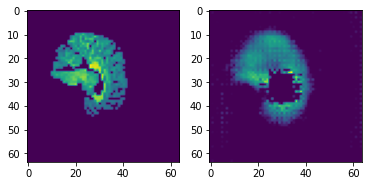

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


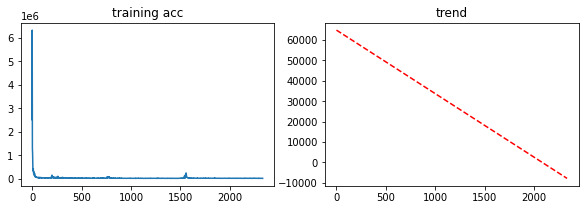

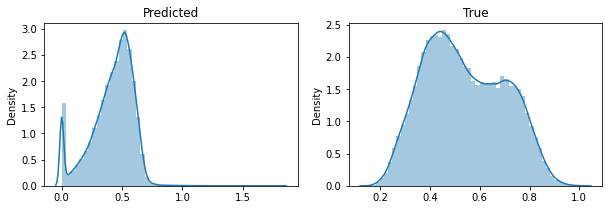

epoch 11/501 | batch 0/212.0 | time 0:26:10.132001 | loss 15260.0
epoch 11/501 | batch 50/212.0 | time 0:26:43.426124 | loss 13642.84082
epoch 11/501 | batch 100/212.0 | time 0:27:16.754635 | loss 9990.07227
epoch 11/501 | batch 150/212.0 | time 0:27:49.924821 | loss 10667.23438
epoch 11/501 | batch 200/212.0 | time 0:28:23.367394 | loss 12108.76465
epoch 12/501 | batch 0/212.0 | time 0:28:31.383757 | loss 11237.17188
epoch 12/501 | batch 50/212.0 | time 0:29:04.603362 | loss 11711.64551
epoch 12/501 | batch 100/212.0 | time 0:29:37.983401 | loss 11121.61816
epoch 12/501 | batch 150/212.0 | time 0:30:11.410481 | loss 12291.79883
epoch 12/501 | batch 200/212.0 | time 0:30:44.764106 | loss 9764.81152
epoch 13/501 | batch 0/212.0 | time 0:30:52.756620 | loss 9867.68164
epoch 13/501 | batch 50/212.0 | time 0:31:26.136425 | loss 12424.69336
epoch 13/501 | batch 100/212.0 | time 0:31:59.492800 | loss 10395.63086
epoch 13/501 | batch 150/212.0 | time 0:32:32.779922 | loss 11365.77539
epoch 13

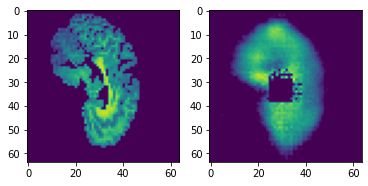

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


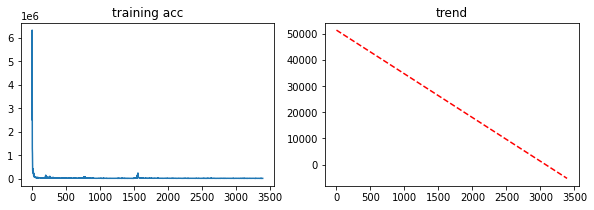

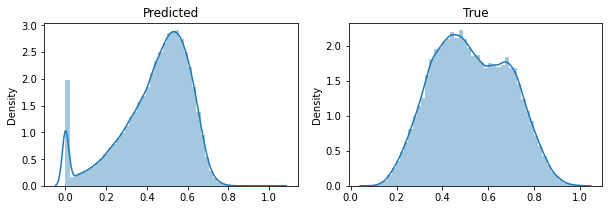

epoch 16/501 | batch 0/212.0 | time 0:38:00.770704 | loss 11672.64844
epoch 16/501 | batch 50/212.0 | time 0:38:34.079975 | loss 12173.35352
epoch 16/501 | batch 100/212.0 | time 0:39:07.268588 | loss 10398.86133
epoch 16/501 | batch 150/212.0 | time 0:39:40.591867 | loss 10724.9082
epoch 16/501 | batch 200/212.0 | time 0:40:14.041676 | loss 10522.52148
epoch 17/501 | batch 0/212.0 | time 0:40:22.068727 | loss 11772.31641
epoch 17/501 | batch 50/212.0 | time 0:40:55.495401 | loss 9474.6543
epoch 17/501 | batch 100/212.0 | time 0:41:28.800019 | loss 9220.48047
epoch 17/501 | batch 150/212.0 | time 0:42:02.090174 | loss 10076.72168
epoch 17/501 | batch 200/212.0 | time 0:42:35.327286 | loss 10225.35938
epoch 18/501 | batch 0/212.0 | time 0:42:43.336459 | loss 10680.08594
epoch 18/501 | batch 50/212.0 | time 0:43:16.789091 | loss 9877.31055
epoch 18/501 | batch 100/212.0 | time 0:43:50.057382 | loss 9289.4043
epoch 18/501 | batch 150/212.0 | time 0:44:23.469687 | loss 13145.45605
epoch 18

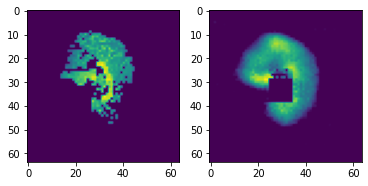

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


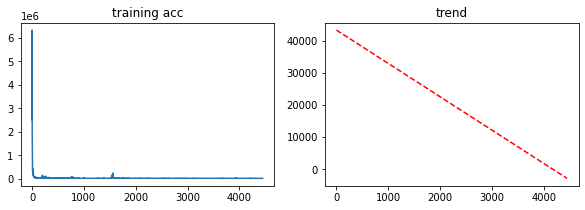

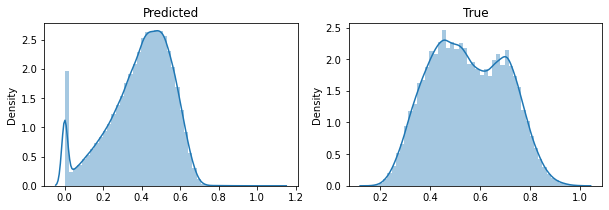

epoch 21/501 | batch 0/212.0 | time 0:49:51.397811 | loss 8154.92969
epoch 21/501 | batch 50/212.0 | time 0:50:24.714374 | loss 8538.06055
epoch 21/501 | batch 100/212.0 | time 0:50:58.060725 | loss 8409.68848
epoch 21/501 | batch 150/212.0 | time 0:51:31.244174 | loss 10963.90234
epoch 21/501 | batch 200/212.0 | time 0:52:04.632809 | loss 14290.15137
epoch 22/501 | batch 0/212.0 | time 0:52:12.664446 | loss 10110.89258
epoch 22/501 | batch 50/212.0 | time 0:52:46.049316 | loss 11919.19824
epoch 22/501 | batch 100/212.0 | time 0:53:19.281129 | loss 8661.31445
epoch 22/501 | batch 150/212.0 | time 0:53:52.585606 | loss 8339.36328
epoch 22/501 | batch 200/212.0 | time 0:54:25.960680 | loss 12902.26758
epoch 23/501 | batch 0/212.0 | time 0:54:33.967220 | loss 10322.73828
epoch 23/501 | batch 50/212.0 | time 0:55:07.293520 | loss 10345.3252
epoch 23/501 | batch 100/212.0 | time 0:55:40.522934 | loss 9400.35254
epoch 23/501 | batch 150/212.0 | time 0:56:13.863954 | loss 8009.94238
epoch 23/

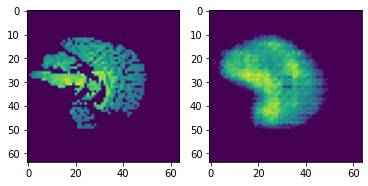

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


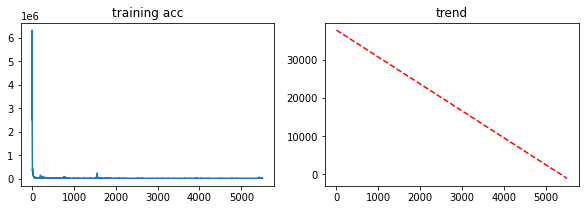

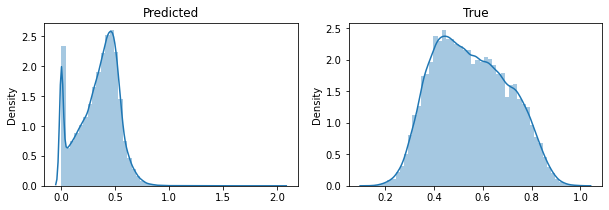

epoch 26/501 | batch 0/212.0 | time 1:01:41.742765 | loss 13837.2168
epoch 26/501 | batch 50/212.0 | time 1:02:15.031752 | loss 10900.38574
epoch 26/501 | batch 100/212.0 | time 1:02:48.271790 | loss 10407.43359
epoch 26/501 | batch 150/212.0 | time 1:03:21.464287 | loss 9373.9707
epoch 26/501 | batch 200/212.0 | time 1:03:54.774005 | loss 8197.77637
epoch 27/501 | batch 0/212.0 | time 1:04:02.783610 | loss 10847.54883
epoch 27/501 | batch 50/212.0 | time 1:04:36.034659 | loss 7547.27051
epoch 27/501 | batch 100/212.0 | time 1:05:09.230598 | loss 10339.66406
epoch 27/501 | batch 150/212.0 | time 1:05:42.423219 | loss 9471.62402
epoch 27/501 | batch 200/212.0 | time 1:06:15.668789 | loss 9703.05469
epoch 28/501 | batch 0/212.0 | time 1:06:23.676236 | loss 13563.50586
epoch 28/501 | batch 50/212.0 | time 1:06:56.944290 | loss 10106.84863
epoch 28/501 | batch 100/212.0 | time 1:07:30.203553 | loss 10549.4043
epoch 28/501 | batch 150/212.0 | time 1:08:03.392340 | loss 10633.42969
epoch 28/

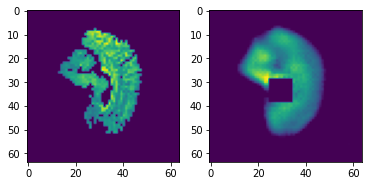

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


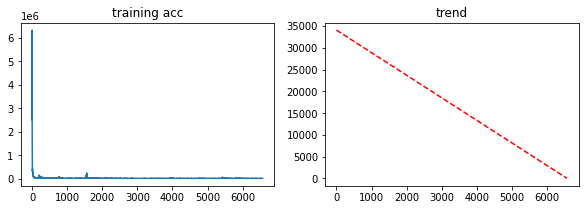

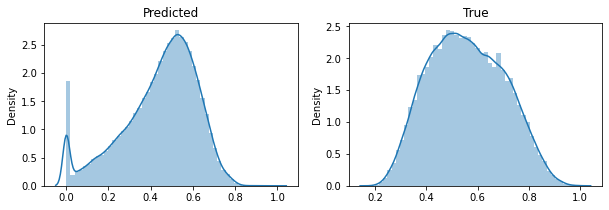

epoch 31/501 | batch 0/212.0 | time 1:13:30.429287 | loss 8788.05273
epoch 31/501 | batch 50/212.0 | time 1:14:03.734404 | loss 7622.35254
epoch 31/501 | batch 100/212.0 | time 1:14:37.054928 | loss 8716.17871
epoch 31/501 | batch 150/212.0 | time 1:15:10.217950 | loss 8605.04102
epoch 31/501 | batch 200/212.0 | time 1:15:43.484695 | loss 8911.62598
epoch 32/501 | batch 0/212.0 | time 1:15:51.475505 | loss 9113.05078
epoch 32/501 | batch 50/212.0 | time 1:16:24.763536 | loss 11649.43555
epoch 32/501 | batch 100/212.0 | time 1:16:57.970885 | loss 8391.79688
epoch 32/501 | batch 150/212.0 | time 1:17:31.196410 | loss 8414.0127
epoch 32/501 | batch 200/212.0 | time 1:18:04.405640 | loss 6732.06104
epoch 33/501 | batch 0/212.0 | time 1:18:12.394796 | loss 8288.99414
epoch 33/501 | batch 50/212.0 | time 1:18:45.634383 | loss 9286.68555
epoch 33/501 | batch 100/212.0 | time 1:19:18.863158 | loss 7289.62842
epoch 33/501 | batch 150/212.0 | time 1:19:52.085950 | loss 11279.05859
epoch 33/501 |

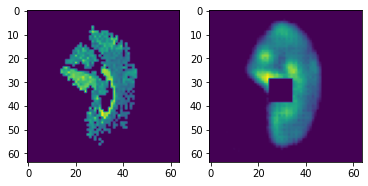

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


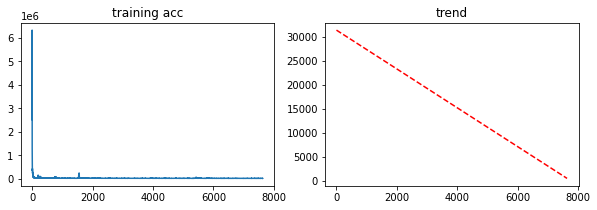

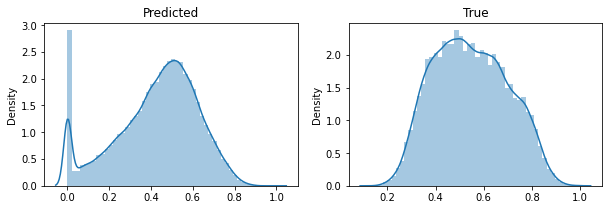

epoch 36/501 | batch 0/212.0 | time 1:25:19.527955 | loss 9473.71191
epoch 36/501 | batch 50/212.0 | time 1:25:52.783831 | loss 9320.44727
epoch 36/501 | batch 100/212.0 | time 1:26:26.145741 | loss 8326.26953
epoch 36/501 | batch 150/212.0 | time 1:26:59.291486 | loss 9460.22656
epoch 36/501 | batch 200/212.0 | time 1:27:32.656631 | loss 9132.47168
epoch 37/501 | batch 0/212.0 | time 1:27:40.682469 | loss 9032.33105
epoch 37/501 | batch 50/212.0 | time 1:28:13.934385 | loss 7819.05664
epoch 37/501 | batch 100/212.0 | time 1:28:47.212716 | loss 8925.26758
epoch 37/501 | batch 150/212.0 | time 1:29:20.485356 | loss 7779.81201
epoch 37/501 | batch 200/212.0 | time 1:29:53.749965 | loss 8179.11035
epoch 38/501 | batch 0/212.0 | time 1:30:01.719647 | loss 8017.41797
epoch 38/501 | batch 50/212.0 | time 1:30:34.974110 | loss 9867.03223
epoch 38/501 | batch 100/212.0 | time 1:31:08.235493 | loss 10060.97656
epoch 38/501 | batch 150/212.0 | time 1:31:41.517733 | loss 7176.48535
epoch 38/501 |

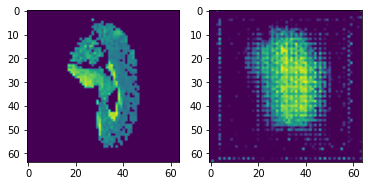

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


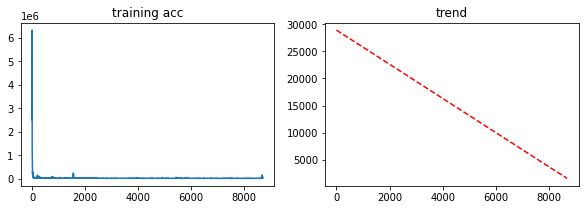

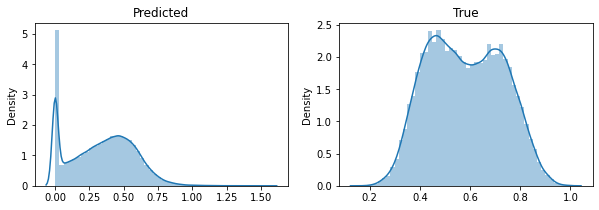

epoch 41/501 | batch 0/212.0 | time 1:37:09.234867 | loss 25310.19727
epoch 41/501 | batch 50/212.0 | time 1:37:42.517825 | loss 17854.54492
epoch 41/501 | batch 100/212.0 | time 1:38:15.709400 | loss 19213.16211
epoch 41/501 | batch 150/212.0 | time 1:38:48.847192 | loss 12361.54883
epoch 41/501 | batch 200/212.0 | time 1:39:22.095048 | loss 13971.70508
epoch 42/501 | batch 0/212.0 | time 1:39:30.067143 | loss 18359.72656
epoch 42/501 | batch 50/212.0 | time 1:40:03.211997 | loss 16916.08008
epoch 42/501 | batch 100/212.0 | time 1:40:36.313591 | loss 10255.99707
epoch 42/501 | batch 150/212.0 | time 1:41:09.496566 | loss 10198.83105
epoch 42/501 | batch 200/212.0 | time 1:41:42.709905 | loss 12066.89062
epoch 43/501 | batch 0/212.0 | time 1:41:50.696538 | loss 11553.36719
epoch 43/501 | batch 50/212.0 | time 1:42:23.922508 | loss 12569.07422
epoch 43/501 | batch 100/212.0 | time 1:42:57.047761 | loss 10709.79102
epoch 43/501 | batch 150/212.0 | time 1:43:30.189779 | loss 10889.82422
e

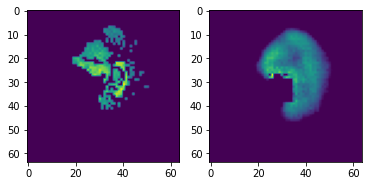

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


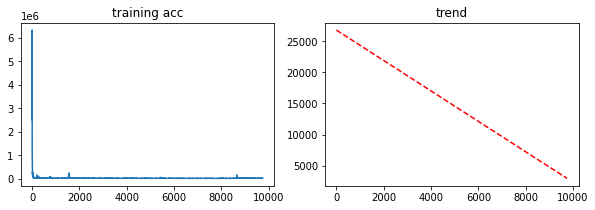

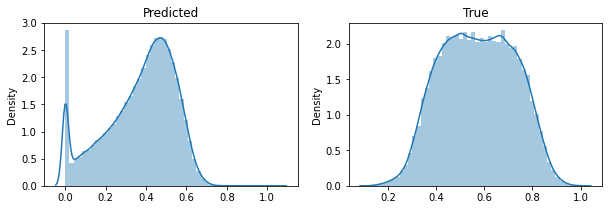

epoch 46/501 | batch 0/212.0 | time 1:48:57.034774 | loss 10787.72461
epoch 46/501 | batch 50/212.0 | time 1:49:30.310617 | loss 11965.09961
epoch 46/501 | batch 100/212.0 | time 1:50:03.558203 | loss 9782.23828
epoch 46/501 | batch 150/212.0 | time 1:50:36.699058 | loss 8571.41406
epoch 46/501 | batch 200/212.0 | time 1:51:10.035816 | loss 10154.99219
epoch 47/501 | batch 0/212.0 | time 1:51:18.062573 | loss 8571.25781
epoch 47/501 | batch 50/212.0 | time 1:51:51.313361 | loss 8204.59863
epoch 47/501 | batch 100/212.0 | time 1:52:24.496752 | loss 10626.74219


In [ ]:
t0 = datetime.now();
for epoch in range(int(num_epochs)):
    permutation = np.random.permutation(ndata)
    D = D[permutation,:,:,:,:]
    for batch_idx in range(int(n_batches)):
        optimizer.zero_grad()
        data_batch = D[batches[batch_idx,:],:,:,:,:]
        outputs = model.forward(data_batch)
        #train_loss = criterion(outputs,data_batch)
        train_loss = myLoss(outputs,data_batch)
        train_loss.backward()
        optimizer.step()
        track.append(train_loss.item())
        if batch_idx%50==0:
          print(f"epoch {epoch}/{num_epochs} | batch {batch_idx}/{n_batches} | time {str(datetime.now()-t0)} | loss {round(train_loss.item(),5)}")


    track = track[-min(len(track),10000)::]

    if epoch%100==0:
      ofn = os.path.join(ofdir,f'{session_name}' + f'e{epoch}_'+str(now()))
      print('saved')
      print(ofn)
      torch.save(model.state_dict(),ofn)
     
    if epoch%5==0:
      print(outputs.view(-1))
      plt.figure()
      plt.subplot(1,2,1)
      plt.imshow(data_batch.cpu().detach().numpy()[0,0,32,:,:])
      plt.subplot(1,2,2)
      plt.imshow(outputs.cpu().detach().numpy()[0,0,32,:,:])
      plt.show()

      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      t = track
      plt.plot(t)
      plt.title('training acc')

      xs = np.arange(len(t))+1
      z = np.polyfit(xs, t, 1)
      p = np.poly1d(z)
      plt.subplot(1,2,2)
      plt.plot(xs,p(xs),"r--")
      plt.title('trend')


      b = outputs.cpu().detach()
      a = data_batch.cpu().detach()
      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      sns.distplot(np.array(b[a>0.001]).flatten())
      plt.title('Predicted')
      plt.subplot(1,2,2)
      sns.distplot(np.array(a[a>0.001]).flatten())
      plt.title('True')
      plt.show()

In [ ]:
 %print('all done')